In [97]:
import sys
import os

# Add the scripts folder to the Python path
sys.path.append(os.path.abspath("../scripts"))  # Adjust the path accordingly

In [98]:
import pandas as pd
import numpy as np
from load_data import *
from viterbi import *
import pickle

In [99]:
data_file = "../data/brown-universal.txt"
tags_file = "../data/tags-universal.txt"
NLTK_model = "../results/hmm_tagger-NLTK.pkl"
BW_model = "../results/hmm_tagger-BW.pkl"

# Viterbi Algorithm

# Make Predictions

With NLTK Trained HMM

In [100]:
with open(NLTK_model, 'rb') as pickle_file:
    hmm_tagger_NLTK = pickle.load(pickle_file)

In [101]:
# Extract model parameters
tags_nltk = hmm_tagger_NLTK._states  # Set of all possible tags
words = hmm_tagger_NLTK._symbols  # Set of all possible words

# convert probability distributions of HMM to dictionaries
transitions = {}
for prev_state in hmm_tagger_NLTK._transitions:
    transitions[prev_state] = {}
    for next_state in tags_nltk:
        transitions[prev_state][next_state] = hmm_tagger_NLTK._transitions[prev_state].prob(next_state)

emissions = {}
for state in tags_nltk:
    emissions[state] = {}
    for word in words:
        emissions[state][word] = hmm_tagger_NLTK._outputs[state].prob(word)

initial = {}
for state in tags_nltk:
    initial[state] = hmm_tagger_NLTK._priors.prob(state)

In [102]:
NLTK_tagger = Predictor(tags_nltk, transitions, emissions, initial)

In [103]:
initial_df = pd.DataFrame([initial], columns=tags_nltk)
initial_df

,NOUN,VERB,PRON,ADV,.,CONJ,ADP,DET,PRT,ADJ,X,NUM
0,0.139433,0.045745,0.15841,0.090192,0.093088,0.052337,0.123552,0.210547,0.035058,0.034259,0.0004,0.01698


In [104]:
emissions_df = pd.DataFrame.from_dict(emissions)
print(sum(emissions_df.iloc[:, 0]))

0.9999999999997577


In [105]:
transitions_df = pd.DataFrame.from_dict(transitions)
print(sum(transitions_df.iloc[:, 0]))

0.9999999999999999


With HMM trained with own Baum-Welch implementation

In [106]:
with open(BW_model, 'rb') as pickle_file:
    hmm_tagger_BW = pickle.load(pickle_file)

In [107]:
# Extract model parameters
tags_bw = hmm_tagger_BW["states"]  # Set of all possible tags
words = hmm_tagger_BW["vocab"]  # Set of all possible words

# convert probability distributions of HMM to dictionaries
transitions = {}
transition_probs = hmm_tagger_BW["transition_probs"]
for prev_idx, prev_state in enumerate(tags_bw):
    transitions[prev_state] = {}
    for next_idx, next_state in enumerate(tags_bw):
        transitions[prev_state][next_state] = transition_probs[prev_idx, next_idx]

emissions = {}
emission_probs = hmm_tagger_BW["emission_probs"]
for state_idx, state in enumerate(tags_bw):
    emissions[state] = {}
    for word_idx, word in enumerate(words):
        emissions[state][word] = emission_probs[state_idx, word_idx]

initial = {}
initial_probs = hmm_tagger_BW["initial_probs"]
for state_idx, state in enumerate(tags_bw):
    initial[state] = initial_probs[state_idx]

In [108]:
BW_tagger = Predictor(tags_bw, transitions, emissions, initial)

In [109]:
initial_df = pd.DataFrame([initial], columns=tags_bw)
initial_df

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.001321,0.001321,0.001321,0.06922,0.06922,0.06922,0.021839,0.021839,0.021839,0.026869,...,0.041075,0.026815,0.026815,0.026815,0.015957,0.015957,0.015957,0.069843,0.069843,0.069843


In [110]:
emissions_df = pd.DataFrame.from_dict(emissions)
print(sum(emissions_df.iloc[:, 0]))

0.9999115312150104


In [111]:
transitions_df = pd.DataFrame.from_dict(transitions)
print(sum(transitions_df.iloc[:, 0]))

1.0


# Evaluate

Data for evaluation

In [112]:
train, test = load_brown_data(data_file, split=0.8)

test_sample = test # can split test to test on a smaller sample
test_sample_sequences= [[token.get_word() for token in sentence] for sentence in test_sample]

Run prediction algorithm

In [113]:
targets = [[token.get_pos() for token in sentence] for sentence in test_sample]

In [114]:
# predictions_nltk = [NLTK_tagger.viterbi(sequence) for sequence in test_sample_sequences]

In [115]:
predictions_bw = [BW_tagger.viterbi(sequence) for sequence in test_sample_sequences]

## Accuracy

In [116]:
def compute_accuracy(actuals, targets):
    """Compute accuracy of guesses comparing to target data.
    actual: list of guesses from the model ex. [['VERB', 'NOUN'], ['DET']]
    target: list values from the test/validation set
    """
    if len(actuals) != len(targets):
        return -1 # the number of actual values should match number of target values
    correct_count = 0
    total_tags = 0
    for actual_tags, target_tags in zip(actuals, targets):
        total_tags += len(actual_tags)
        if len(actual_tags) != len(target_tags):
            return -1 # the number of actual values should match number of target values
        for actual_value, target_value in zip(actual_tags, target_tags):
            if actual_value == target_value:
                correct_count += 1
    
    return correct_count/total_tags

Evaluate NLTK Trained model

In [117]:
# print(compute_accuracy(predictions_nltk, targets))

Evaluate HMM trained with own Baum-Welch algorithm

In [118]:
print(compute_accuracy(predictions_bw, targets))

0.0


## Confusion Matrix

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_hmm_confusion_matrix(true_states, predicted_states, title="HMM States Confusion Matrix", 
                               state_names=None, normalize=True):
    """
    Create and visualize a confusion matrix for HMM state predictions.
    
    Parameters:
    -----------
    true_states : list or array
        The true hidden state sequences from your labeled test data
    predicted_states : list or array
        The Viterbi-decoded state sequences from your model
    title : str
        Title for the confusion matrix plot
    state_names : list, optional
        Names of the hidden states (if they have semantic meaning)
    normalize : bool
        Whether to normalize the confusion matrix by row
    
    Returns:
    --------
    cm : numpy.ndarray
        The confusion matrix
    """
    # Flatten sequences if they're nested
    if isinstance(true_states[0], (list, np.ndarray)):
        true_flat = np.concatenate(true_states)
        pred_flat = np.concatenate(predicted_states)
    else:
        true_flat = np.array(true_states)
        pred_flat = np.array(predicted_states)
    
    # Get unique states
    unique_states = sorted(set(np.concatenate([np.unique(true_flat), np.unique(pred_flat)])))
    
    # Create confusion matrix
    cm = confusion_matrix(true_flat, pred_flat, labels=unique_states)
    
    # Normalize if requested
    if normalize:
        cm_plot = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        cm_plot = cm
        fmt = 'd'
    
    # Visualization
    plt.figure(figsize=(10, 8))
    if state_names is None:
        state_names = [f"State {i}" for i in unique_states]
    
    sns.heatmap(cm_plot, annot=True, fmt=fmt, cmap='BuPu',
                xticklabels=state_names, yticklabels=state_names)
    plt.xlabel('Predicted States')
    plt.ylabel('True States')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return cm

/tmp/ipykernel_4719/1332028290.py:44: RuntimeWarning: invalid value encountered in divide
  cm_plot = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
/home/ezgibas/.local/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ezgibas/.local/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


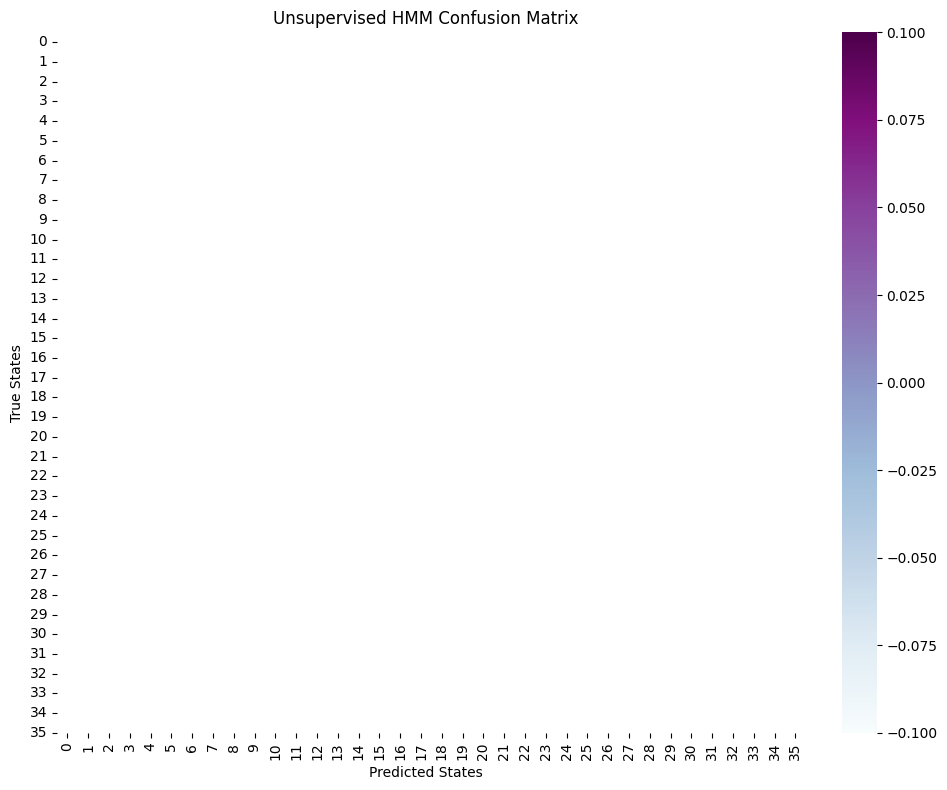

Top 5 most problematic sequences:
Sequence 8183: 180 errors
  True:      ['CONJ', '.', 'NOUN', '.', 'PRT', 'VERB', '.', 'ADP', 'ADV', 'ADJ', 'ADP', 'NUM', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'VERB', 'NOUN', '.', 'ADJ', 'NOUN', 'ADP', 'VERB', 'VERB', 'PRT', 'VERB', '.', 'VERB', '.', 'CONJ', 'VERB', 'PRT', 'DET', 'NOUN', 'ADP', 'NOUN', 'CONJ', 'NOUN', 'VERB', 'ADP', 'ADP', 'DET', 'NOUN', '.', 'VERB', '.', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'NUM', 'NOUN', 'ADP', 'NOUN', 'CONJ', 'NOUN', 'VERB', '.', 'ADJ', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PRT', 'VERB', 'ADP', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'ADP', 'DET', 'VERB', 'NOUN', '.', 'VERB', 'VERB', 'ADP', 'NOUN', 'ADP', 'ADJ', 'CONJ', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'VERB', 'NOUN', '.', 'CONJ', 'VERB', 'ADV', '.', 'ADP', 'DET', 'ADJ', 'NOUN', 'CONJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'CONJ', 'ADJ',

TypeError: sequence item 0: expected str instance, Token found

In [120]:
# - targets: list of true state sequences from your test data
# - predictions_nltk: predictions from your supervised model
# - predictions_bw: predictions from your unsupervised model

# Confusion matrices
# supervised_cm = create_hmm_confusion_matrix(
#     targets, 
#     predictions_nltk,
#     state_names=tags_nltk,
#     title="Supervised HMM Confusion Matrix"
# )

unsupervised_cm = create_hmm_confusion_matrix(
    targets, 
    predictions_bw,
    state_names=tags_bw,
    title="Unsupervised HMM Confusion Matrix"
)

#  Detailed error analysis
def analyze_errors(cm, true_states, pred_states):
    """Analyze which sequences have the most errors"""  
    # Calculate errors per sequence
    errors = []
    for true_seq, pred_seq in zip(true_states, pred_states):
        errors.append(sum(t != p for t, p in zip(true_seq, pred_seq)))
    
    # Find most problematic sequences
    sorted_indices = np.argsort(errors)[::-1]
    
    print("Top 5 most problematic sequences:")
    for i in sorted_indices[:5]:
        print(f"Sequence {i}: {errors[i]} errors")
        print(f"  True:      {[s for s in true_states[i]]}")
        print(f"  Predicted: {[s for s in pred_states[i]]}")
        sequence = " ".join(test_sample[i])
        print(f"{sequence}")
        print()

# Analyze errors for supervised model
# analyze_errors(supervised_cm, targets, predictions_nltk)
analyze_errors(supervised_cm, targets, predictions_bw)